In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/DATA606 Capstone/Raw Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DATA606 Capstone/Raw Data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('crash_weather_2015-2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129145 entries, 0 to 129144
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  129145 non-null  int64  
 1   X                           129145 non-null  float64
 2   Y                           129145 non-null  float64
 3   OBJECTID                    129145 non-null  int64  
 4   CRIMEID                     129145 non-null  int64  
 5   CCN                         129145 non-null  object 
 6   REPORTDATE                  129145 non-null  object 
 7   ROUTEID                     129145 non-null  object 
 8   MEASURE                     129145 non-null  float64
 9   OFFSET                      129145 non-null  float64
 10  STREETSEGID                 113667 non-null  float64
 11  ROADWAYSEGID                113667 non-null  float64
 12  FROMDATE                    129145 non-null  object 
 13  TODATE        

In [4]:
df = df[df['TOTAL_VEHICLES'] > 0]

In [5]:
df['REPORTDATE'] = pd.to_datetime(df['REPORTDATE'], errors='coerce')
df = df.loc[(df['REPORTDATE'].dt.year > 2015) & (df['REPORTDATE'].dt.year < 2020)]

# Extract year, month, day, hour and weekday
df['YEAR']=df['REPORTDATE'].dt.year
df['MONTH']=df['REPORTDATE'].dt.strftime('%b')
df['HOUR']=df['REPORTDATE'].dt.hour
df['WEEKDAY']=df['REPORTDATE'].dt.strftime('%a')

In [6]:
targets = ['MAJORINJURIES_DRIVER', 'MINORINJURIES_DRIVER', 'FATAL_DRIVER'] 
features = ['Precipitation', 'Conditions', 'MONTH', 'HOUR', 'WEEKDAY']

In [7]:
df1 = df[(df['MAJORINJURIES_DRIVER'] > 0) | (df['MINORINJURIES_DRIVER'] > 0) | (df['FATAL_DRIVER'] > 0)] 
label_df = df1[['MINORINJURIES_DRIVER','MAJORINJURIES_DRIVER','FATAL_DRIVER']]
label_df.head()

,MINORINJURIES_DRIVER,MAJORINJURIES_DRIVER,FATAL_DRIVER
22411,1,0,0
22414,1,0,0
22430,1,0,0
22440,1,0,0
22442,1,0,0


In [8]:
print(df['MAJORINJURIES_DRIVER'].value_counts())
print(df['MINORINJURIES_DRIVER'].value_counts())
print(df['FATAL_DRIVER'].value_counts())

0    105561
1       849
2        17
3         2
Name: MAJORINJURIES_DRIVER, dtype: int64
0     90057
1     14270
2      1939
3       140
4        15
5         6
11        1
6         1
Name: MINORINJURIES_DRIVER, dtype: int64
0    106365
1        63
2         1
Name: FATAL_DRIVER, dtype: int64


In [9]:
label_df.loc[label_df['MAJORINJURIES_DRIVER'] > 0, ['Severity']] = 0
label_df.loc[label_df['MINORINJURIES_DRIVER'] > 0, ['Severity']] = 1
label_df.loc[label_df['FATAL_DRIVER'] > 0, ['Severity']] = 2

In [10]:
print(label_df['Severity'].value_counts())

1.0    16363
0.0      725
2.0       64
Name: Severity, dtype: int64


In [11]:
df_features=df1[features].copy()
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17152 entries, 22411 to 129143
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precipitation  17152 non-null  float64
 1   Conditions     17152 non-null  object 
 2   MONTH          17152 non-null  object 
 3   HOUR           17152 non-null  int64  
 4   WEEKDAY        17152 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 804.0+ KB


In [12]:
df_features.shape

(17152, 5)

In [13]:
df_features.isnull().sum()

Precipitation    0
Conditions       0
MONTH            0
HOUR             0
WEEKDAY          0
dtype: int64

In [14]:
df_features = pd.get_dummies(df_features)
df_features.columns

Index(['Precipitation', 'HOUR', 'Conditions_Clear', 'Conditions_Overcast',
       'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'MONTH_Apr', 'MONTH_Aug',
       'MONTH_Dec', 'MONTH_Feb', 'MONTH_Jan', 'MONTH_Jul', 'MONTH_Jun',
       'MONTH_Mar', 'MONTH_May', 'MONTH_Nov', 'MONTH_Oct', 'MONTH_Sep',
       'WEEKDAY_Fri', 'WEEKDAY_Mon', 'WEEKDAY_Sat', 'WEEKDAY_Sun',
       'WEEKDAY_Thu', 'WEEKDAY_Tue', 'WEEKDAY_Wed'],
      dtype='object')

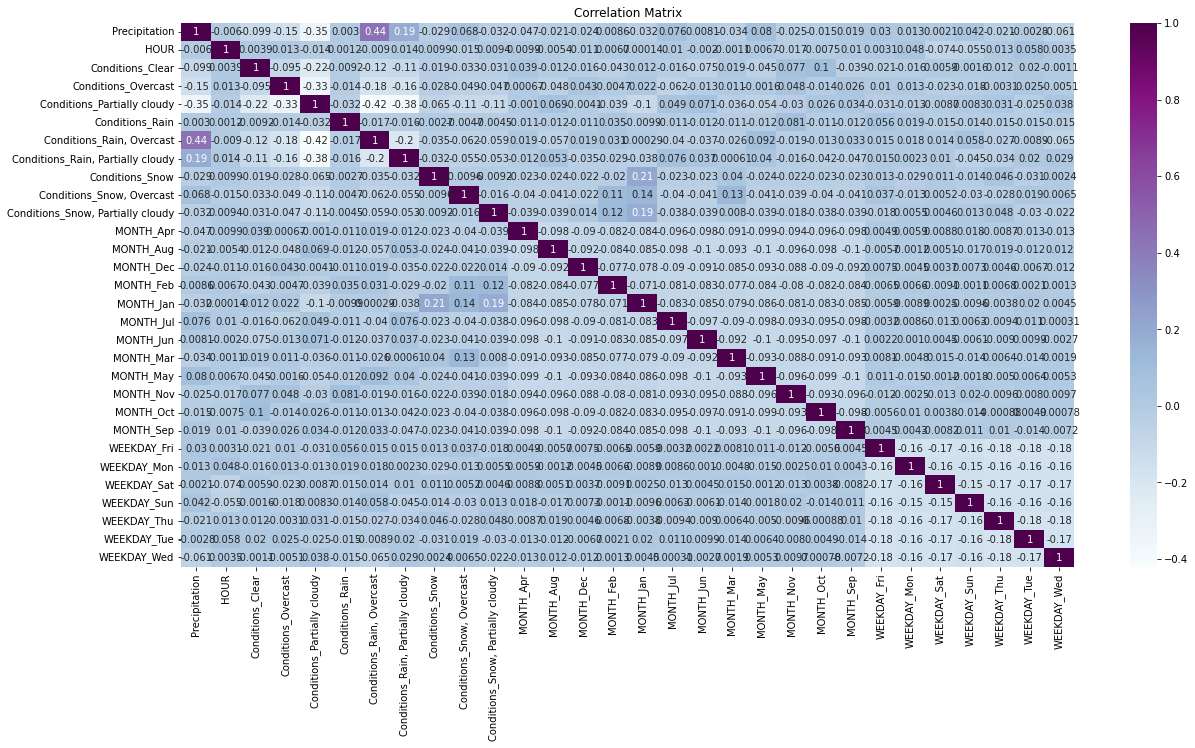

In [15]:
heat_corr = df_features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(heat_corr, annot=True, cmap='BuPu')
plt.title("Correlation Matrix")
plt.show()

In [16]:
hour_dummy = pd.get_dummies(df_features['HOUR'])
hour_dummy.columns = ['Hour_0','Hour_1','Hour_2','Hour_3','Hour_4','Hour_5','Hour_6','Hour_7','Hour_8','Hour_9',
                 'Hour_10','Hour_11','Hour_12','Hour_13','Hour_14','Hour_15','Hour_16','Hour_17','Hour_18',
                 'Hour_19','Hour_20','Hour_21','Hour_22','Hour_23']
df_features = pd.concat([df_features, hour_dummy] , axis = 1)

In [17]:
df_features.drop(columns='HOUR', inplace=True)
df_features.columns

Index(['Precipitation', 'Conditions_Clear', 'Conditions_Overcast',
       'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'MONTH_Apr', 'MONTH_Aug',
       'MONTH_Dec', 'MONTH_Feb', 'MONTH_Jan', 'MONTH_Jul', 'MONTH_Jun',
       'MONTH_Mar', 'MONTH_May', 'MONTH_Nov', 'MONTH_Oct', 'MONTH_Sep',
       'WEEKDAY_Fri', 'WEEKDAY_Mon', 'WEEKDAY_Sat', 'WEEKDAY_Sun',
       'WEEKDAY_Thu', 'WEEKDAY_Tue', 'WEEKDAY_Wed', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23'],
      dtype='object')

In [18]:
print(df_features.shape)
print(label_df.shape)

(17152, 53)
(17152, 4)


## Random Forest Classifer

In [19]:
y = label_df['Severity']
X = df_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [21]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.05      0.02      0.03       213
         1.0       0.95      0.99      0.97      4908
         2.0       0.00      0.00      0.00        25

    accuracy                           0.94      5146
   macro avg       0.34      0.33      0.33      5146
weighted avg       0.91      0.94      0.93      5146



In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[   4,  208,    1],
       [  70, 4837,    1],
       [   0,   25,    0]])

## SMOTE

In [23]:
print('After OverSampling, the shape of train_X: {}'.format(X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y.shape))

print("Before OverSampling, counts of label '0': {}".format(sum(y_train == 0)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '2': {} \n".format(sum(y_train == 2)))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))
print("After OverSampling, counts of label '1': {} \n".format(sum(y_res == 1)))
print("After OverSampling, counts of label '2': {} \n".format(sum(y_res == 2)))

After OverSampling, the shape of train_X: (17152, 53)
After OverSampling, the shape of train_y: (17152,) 

Before OverSampling, counts of label '0': 512
Before OverSampling, counts of label '1': 11455 

Before OverSampling, counts of label '2': 39 

After OverSampling, the shape of train_X: (34365, 53)
After OverSampling, the shape of train_y: (34365,) 

After OverSampling, counts of label '0': 11455
After OverSampling, counts of label '1': 11455 

After OverSampling, counts of label '2': 11455 



In [24]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [25]:
rf2 = RandomForestClassifier(n_estimators=100, random_state=42)

rf2.fit(X_train_res, y_train_res)

y_pred_res1 = rf.predict(X_test_res)

In [26]:
print(metrics.classification_report(y_test_res, y_pred_res1))

              precision    recall  f1-score   support

         0.0       0.97      0.02      0.04      3421
         1.0       0.34      1.00      0.50      3445
         2.0       1.00      0.00      0.00      3444

    accuracy                           0.34     10310
   macro avg       0.77      0.34      0.18     10310
weighted avg       0.77      0.34      0.18     10310



In [27]:
confusion_matrix = metrics.confusion_matrix(y_test_res, y_pred_res1)
confusion_matrix

array([[  70, 3351,    0],
       [   2, 3443,    0],
       [   0, 3440,    4]])

### CV Grid Search

In [28]:
param_grid = { 
    'n_estimators': [100,200,400,600,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth'   : [4,6,8],
    'criterion'   :['gini', 'entropy']
}

In [29]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 400, 600, 800]})

In [30]:
print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 400}


In [31]:
rf2 = RandomForestClassifier(n_estimators=400, 
                              criterion='entropy', 
                              max_features='log2',
                              max_depth=8,
                              random_state=42)

rf2.fit(X_train_res, y_train_res)

y_pred_res2 = rf2.predict(X_test_res)

In [32]:
print(metrics.classification_report(y_test_res, y_pred_res2))

              precision    recall  f1-score   support

         0.0       0.77      0.48      0.59      3421
         1.0       0.82      0.75      0.78      3445
         2.0       0.65      0.96      0.77      3444

    accuracy                           0.73     10310
   macro avg       0.75      0.73      0.71     10310
weighted avg       0.75      0.73      0.72     10310



In [33]:
confusion_matrix = metrics.confusion_matrix(y_test_res, y_pred_res2)
confusion_matrix

array([[1626,  552, 1243],
       [ 335, 2575,  535],
       [ 146,    5, 3293]])

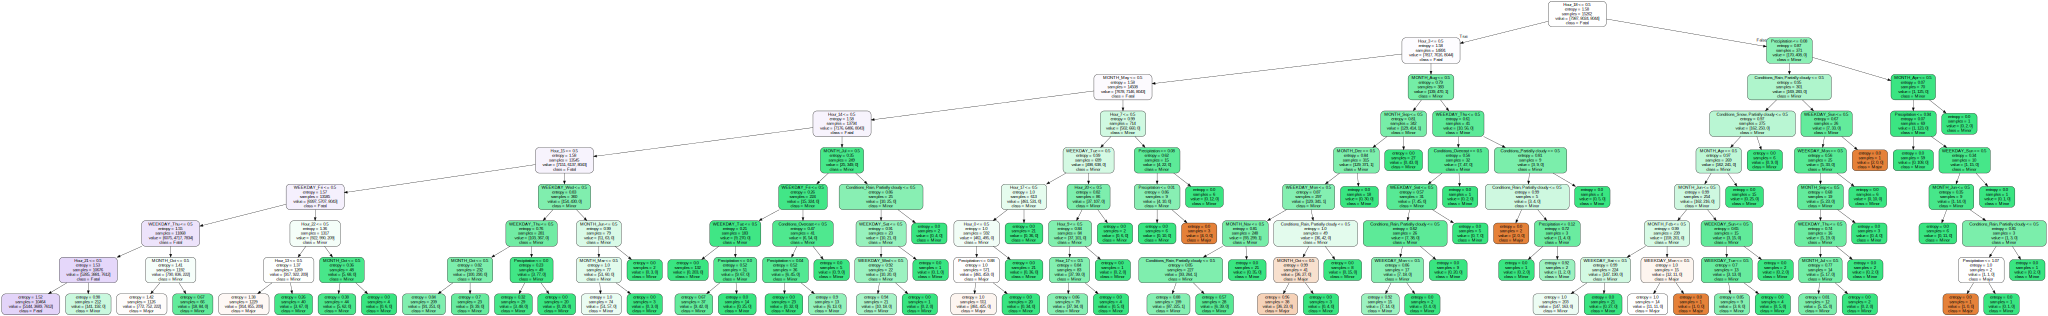

In [34]:
import graphviz
from sklearn.tree import export_graphviz
cn=['Major', 'Minor', 'Fatal']

# Export as dot file
tree = export_graphviz(rf2.estimators_[0], 
                out_file= None,
                feature_names = X_train.columns,
                class_names = cn,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
graphviz.Source(tree)

## Feature Importance

In [35]:
importances =rf2.feature_importances_

In [36]:
imp = pd.DataFrame(importances)
imp['Features'] = df_features.columns
imp.rename(columns={0:'Importance'}, inplace=True)
imp = imp.sort_values(by='Importance', ascending=False)
imp = imp[['Features', 'Importance']]
imp

,Features,Importance
24,WEEKDAY_Sat,0.087428
18,MONTH_May,0.080564
22,WEEKDAY_Fri,0.071461
26,WEEKDAY_Thu,0.068539
19,MONTH_Nov,0.065304
11,MONTH_Aug,0.048057
43,Hour_14,0.041027
29,Hour_0,0.034576
44,Hour_15,0.033835
0,Precipitation,0.032447


In [37]:
fig = px.bar(imp, x='Importance', y='Features', title='Feature Importance', color ='Features', orientation='h')
fig.show()